# Video Actor Synchroncy and Causality (VASC)
## RAEng: Measuring Responsive Caregiving Project
### Caspar Addyman, 2020
### https://github.com/infantlab/VASC

# Step 3: Analyse the data using scipy statsmodels

This script correlates and compares the timeseries of wireframes for the two figures in the video `["parent", "infant"]`

We start by reloading the saved parquet file containing the multi-index numpy array of all [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) data from all pairs of individuals. 



In [ ]:
import sys
import os
import json
import math
import numpy as np       
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
%matplotlib inline

import logging
import ipywidgets as widgets  #let's us add buttons and sliders to this page.
from ipycanvas import Canvas

import vasc #a module of our own functions (found in vasc.py in this folder)

#turn on debugging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%pdb on

## 2.1 Settings?

Load a json file that tells us where to find our videos and where to save the data. You should create a different settings file for each project. Then you don't need to change any other values in the script for Step 1 or Step 2.

TODO - write a helper to create a settings file


In [ ]:
settingsjson = "C:\\Users\\cas\\OneDrive - Goldsmiths College\\Projects\\Little Drummers\\VASC\\settings.json"

try:
    with open(settingsjson) as json_file:
        settings = json.load(json_file)
        print("Existing settings.json found..")
except json.JSONDecodeError:
    logging.exception("Settings file was not valid JSON.")
except Exception as e:
        emsg = str(e)
        #show the error
        print("Error: ",emsg)
        print("No setting.json file found!\nPlease see Step 0 for instructions")

Existing settings.json found..


In [3]:
includeHands = settings["flags"]["includeHands"]

In [4]:
anon = settings["flags"]["anon"]

In [5]:
# where's the project data folder? (with trailing slash)
projectpath = settings["paths"]["project"]
#where are your video files? 
videos_in = settings["paths"]["videos_in"]

# locations of videos and output
videos_out = settings["paths"]["videos_out"]
videos_out_openpose   = settings["paths"]["videos_out_openpose"]
videos_out_timeseries = settings["paths"]["videos_out_timeseries"]
videos_out_analyses   = settings["paths"]["videos_out_analyses"]

print(videos_in)
print(videos_out)
print(videos_out_openpose)
print(videos_out_timeseries)
print(videos_out_analyses)

C:\Users\cas\OneDrive - Goldsmiths College\Projects\Little Drummers\test
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Little Drummers\testhandsout
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Little Drummers\testhandsout\openpose
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Little Drummers\testhandsout\timeseries
C:\Users\cas\OneDrive - Goldsmiths College\Projects\Little Drummers\testhandsout\analyses


### 3.1 Load the clean data as a DataFrame

Reload the clean data file created in step 2. 

In [6]:
#retrieve the list of base names of processed videos.
videosjson = settings["paths"]["videos_out"] + '\\' + settings["filenames"]["clean_json"]
try:
    with open(videosjson) as json_file:
        videos = json.load(json_file)
        print("Existing clean.json found..")
except:
    videos = {}
    print("No clean.json file found, please locate the file or complete Step 2 first.")

Existing clean.json found..


In [7]:
print('reading parquet file:')
df = pq.read_table(videos_out_timeseries + '\\' + settings["filenames"]["cleandataparquet"]).to_pandas()
if includeHands:
    lh = pq.read_table(videos_out_timeseries + '\\' + settings["filenames"]["lefthandparquet"]).to_pandas()
    rh = pq.read_table(videos_out_timeseries + '\\' + settings["filenames"]["righthandparquet"]).to_pandas()

#sort the column names as this helps with indexing
df = df.sort_index(axis = 1)
print(df.head())

reading parquet file:
video  768fa72_04-test-trials                                                 \
person                 infant                                                  
coord                      0        1         2        3        4         5    
0                     709.733  241.366  0.839737  688.168  341.393  0.679924   
1                     711.594  241.433  0.867754  688.172  345.313  0.672489   
2                     709.691  241.426  0.852793  690.076  343.375  0.666712   
3                     709.629  241.384  0.839603  688.175  341.413  0.674385   
4                     707.709  241.386  0.829629  686.226  343.349  0.668549   

video                                        ... sinead_14-test-trials       \
person                                       ...                parent        
coord        6        7         8        9   ...                    65   66   
0       562.767  337.440  0.569439  503.966  ...                   0.0  0.0   
1       562.759  337.

## 3.2 Process the data 

Next we set all 0 values to as missing value `np.nan` to enable interpolation.
Then use numpy's built in `interpolate` method. 

In [8]:
df = df.replace(0.0, np.nan)
if includeHands:
    rh = rh.replace(0.0, np.nan)
    lh = lh.replace(0.0, np.nan)

In [9]:
df.shape

(956, 4500)

In [10]:
#are we going to use all the data or a subset?
first = 0
last = 2989 

df = df.truncate(before  = first, after = last)

In [11]:
#linear interpolate missing values 
df = df.interpolate()  
#may still have some NaNs at start so back fill these with first non-zero value
#eg  [NaN, NaN, 3.1, 3.2, ...] -> [3.1, 3.1, 3.1, 3.2, ...]
df = df.fillna(method = 'backfill')

if includeHands:
    rh = rh.interpolate()  
    rh = rh.fillna(method = 'backfill')
    lh = lh.interpolate() 
    lh = lh.fillna(method = 'backfill')


In [ ]:
#take a quick look
print(df.head())
df.shape

In [ ]:
print(lh.head())

### 3.2.1 Mean movements
We create a dictionary of the subsets of OpenPose coordinates we want to average and then call `mean` on the Pandas dataframe. e.g.

```
meanpoints = {
               "headx" : [0, 3, 45, 48, 51, 54],
               "heady" : [1, 4, 46, 49, 52, 55],
               "allx" :  [0, 3, 6, 9, ...],
               "ally" :  [1, 4, 7, 10, ...]
             }
```

Then we call the `vasc.averageCoordinateTimeSeries` function to average across sets of coordinates. For a given set of videos and people. For example

In:
```
videos = "All"
people = "Both"
df2 = vasc.averageCoordinateTimeSeries(df,meanpoints,videos,people)
df2.head
```

Out:
```
person      infant                                          parent   
avgs         headx       heady          xs          ys       headx   
501     565.996600  369.840600  534.895615  398.482538  471.686200   
502     567.231800  369.887600  534.354198  398.706552  471.849400   
503     567.228600  370.159600  534.444328  398.678133  471.711600   
504     566.912600  369.857000  535.369536  398.551636  472.309400
...            ...         ...         ...         ...         ...
```


In [14]:
meanpoints = {"head" : vasc.headxys,
              "headx": vasc.headx,
              "heady": vasc.heady,
              "arms" : vasc.armsxys,
              "armsx": vasc.armsx,
              "armsy": vasc.armsy,
              "leftarm" : vasc.leftarmxys,
              "leftarmx": vasc.leftarmx,
              "leftarmy": vasc.leftarmy,
              "rightarm" : vasc.rightarmxys,
              "rightarmx": vasc.rightarmx,
              "rightarmy": vasc.rightarmy,
              "all"  : vasc.xys,
              "allx" : vasc.xs,
              "ally" : vasc.ys
             }

vids = "All"
people = ["infant","parent"]

#average across the points in each group (all points of head etc. )
avgdf = vasc.averageCoordinateTimeSeries(df,meanpoints,vids,people)

hps = {"hand" : vasc.hxys,
       "handx" : vasc.hxs,
       "handy" : vasc.hys}

avglh = vasc.averageCoordinateTimeSeries(lh,hps,vids,people)
avgrh = vasc.averageCoordinateTimeSeries(rh,hps,vids,people)


In [ ]:
hps

In [ ]:
avgdf.head

In [ ]:
%pdb on

### 3.2.2 Rolling window of movements

One thing we'd like to know is if mothers move in response to infants. The raw time series are probably too noisy to tell us this so instead we can look at few alternatives

1. **Smoothed** - if we average the signal over a short rolling window we smooth out any high-frequency jitter. 
2. **Variance** - the variance of movement over a short rolling window. First we apply short (10 frame) rolling window to each coordinate of the body and use the stddev or variance function `std()` or `var()` . Then we take averages as in the step above. However, this time we combine x and y coordinates as this is now a movement index. 




In [ ]:
win = 10 #10 frames better for rhythm detcion
halfwin = math.floor(win/2)

smoothdf = df.rolling(window = 5).mean()
smoothdf = smoothdf.truncate(before  = first, after = last)

vardf = df.rolling(window = win, min_periods = halfwin).var()
vardf = vardf.truncate(before  = first , after = last) # cut out the empty bits at the start
 
smoothdf = vasc.averageCoordinateTimeSeries(smoothdf,meanpoints,vids,people)
vardf = vasc.averageCoordinateTimeSeries(vardf,meanpoints,vids,people)

## Visualising the data

Let's create a widget to plot some graphs of the data

In [ ]:
vidlist = [] #used to fill dropdown options
for vid in videos:  
    vidlist.append(vid)
        
pickvid = widgets.Dropdown(
    options= vidlist,
    value= vidlist[0],
    description='Subject:'
)

features = []
for f in meanpoints:
    features.append(f)
    
pickfeature = widgets.Dropdown(
    options= features,
    value= features[0],
    description='Feature:'
)

linetypes = ["Mean point", "Smoothed Mean (5 frames)","Variance over 2 secs"]
picktype = widgets.Dropdown(
    options= linetypes,
    value= linetypes[0],
    description='Line type:'
)

def pickvid_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)
        
def pickfeature_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)

def picktype_change(change):
    if change['name'] == 'value' and (change['new'] != change['old']):
        updateAll(True)
        
pickvid.observe(pickvid_change, 'value') 
pickfeature.observe(pickfeature_change, 'value') 
picktype.observe(picktype_change, 'value') 
button_update = widgets.Button(description="Redraw")
output = widgets.Output()


def drawGraphs(vid, feature, linetype):
    """Plot input signals"""
    plt.ion()

    f,ax=plt.subplots(4,1,figsize=(14,10),sharex=True)
    ax[0].set_title('Infant')
    ax[1].set_title('Parent')
    ax[1].set_xlabel('Frames')

    who = ["infant","parent"]

    if linetype == linetypes[0]:
        usedf = avgdf
    elif linetype == linetypes[1]:
        usedf = smoothdf
    else:
        usedf = vardf
        
    #to select a single column..
    infant = usedf[(vid, people[0], feature)].to_frame()
    parent = usedf[(vid, people[1], feature)].to_frame()
    n  = np.arange(usedf.shape[0])
    
    #selecting multiple columns slightly messier
    #infant = df3.loc[50:,(vid, part[0], ('head','arms', 'all'))]
    #parent = df3.loc[50:,(vid, part[1], ('head','arms', 'all'))]

    ax[0].plot(n,infant)
    ax[1].plot(n,parent, color='b')
    
    #calculate the correlations in a shorter rolling window
    r_window_size = 120
    rolling_r = usedf[(vid, who[0], feature)].rolling(window=r_window_size, center=True).corr(vardf[(vid, who[1], feature)])


    usedf.loc[:,(vid, slice(None), feature)].plot(ax=ax[2])
    ax[2].set(xlabel='Frame',ylabel='Movement index for parent and infant')

    rolling_r.plot(ax=ax[3])
    ax[3].set(xlabel='Frame',ylabel='Pearson r')
    ax[3].set_title("Local correlation with rolling window size " + str(r_window_size))

    plt.show() 

def updateAll(forceUpdate = False):
    output.clear_output(wait = True)
    if forceUpdate:
        logging.debug('forceUpdate')
        #slider.value = 0
        #slider.max = videos[pickvid.value][pickcam.value]["end"]
    with output:
        display(pickvid,pickfeature,picktype,button_update)  
        drawGraphs(pickvid.value,pickfeature.value,picktype.value)
    
#draw everything for first time
updateAll(True)
output

### 3.3 Fitting the best periodic function.

For each infant and each trial we try to find the best

In [ ]:
vid = "424a7d7_04-test-trials"

armmov = avgdf[(vid, people[0], 'leftarm')].to_frame()
armmov.head


In [ ]:
who = ["infant","parent"]
parts = ["head","arms","all"]

In [ ]:
#loop through colculate for each pair
for vid in videos:
    thisrow = []
    for part in parts:
        #to select a single column..
        pearson = vardf[(vid, people[0], part)].corr(vardf[(vid, people[1], part)])
 
        thisrow.append(pearson) #this is for correlation
        thisrow.append(None) #this is for maximum lag
    
    thisrow.append(None) #don't have DyadSynScore yet 
    results.loc[vid] = thisrow

## Fitting the best periodic function

We use the scipy [least squares optimiser](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit) to find the best fitting sine wave, estimating phase, frequency and amplitude.

Because each video could have a different frame rate (fps) we have to make a note of that each time.

This page provides a quick example
https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html

In [ ]:
import time
import scipy
import numpy as np
from scipy import optimize
import pylab as plt


#the function that we want to fit to our data. 
#basically a sine wave where we optimize everything - especially frequency.
def optimize_func(x_time, amp, freq, phase, mean):
    return amp * np.sin(2 * math.pi * freq * x_time + phase) + mean

In [ ]:
plotgraphs = True
showfirstguess = False
savedata = True
GuessSMT  = 450  #we expect infants to have a spontaneous ISI of 450 ms
GuessFreq = 1000 / GuessSMT

bodypart = 'leftarmy'

failarray = [math.nan, math.nan, math.nan, math.nan,math.nan]  #empty array if we fail to fit function


results = pd.DataFrame(columns = ("fit measure", "best_amp","best_freq","best_phase","best_mean","fps","fitted_isi","message"), index = videos)

for vid in videos:
    #retrieve the raw data for this video
    frames = videos[vid]['camera1']['frames']    #how many frames?
    fps = videos[vid]['camera1']['fps']          #how many frames per second?
    x_data = np.linspace(0,frames,frames+1)      #x axis
    x_time = x_data / fps                        #x axis in units of time (seconds)
    armmov = avgdf[(vid, people[0], bodypart)]  #get the averaged data
    y_data = armmov.truncate(before = 0, after = frames).to_numpy()  #convert to numpy array
    
    try:
        #have a first guess of the parameters
        guess_mean = float(np.mean(armmov))
        guess_amp =  2* float(np.std(armmov))
        guess_phase = 0.0
        guess_freq = GuessFreq
        
        # we'll use this to plot our first estimate. This might already be good enough for you
        data_first_guess = optimize_func(x_time, guess_amp, guess_freq, guess_phase, guess_mean)

        #now optimize
        params, params_covariance = optimize.curve_fit(optimize_func, x_time, y_data,
                                                   p0=[guess_amp, guess_freq,guess_phase,guess_mean])

        #what is the best fit?
        fitted = optimize_func(x_time, params[0],params[1],params[2],params[3])

        #how far is this from raw data?
        best_fit = scipy.spatial.distance.euclidean(y_data,fitted )

        if savedata:
            #save all values to dataframe
            vals = [best_fit] 
            vals.extend(params)
            vals.append(fps)
            vals.append(1000/(params[1]))  #fitted isi
            vals.append("Success")
            print(vals)
            results.loc[vid] = vals

        if plotgraphs:
            #plot the functions
            plt.figure(figsize=(6, 4),)
            plt.plot(x_time, y_data, label='Data')
            if showfirstguess: 
                plt.plot(x_time, data_first_guess, label = 'First guess')
            plt.plot(x_time, fitted,label='Fitted function')
            plt.title(vid + " " + bodypart)
            plt.legend(loc='best')

            plt.show()

    except Exception as e:
        #emsg = "".join(str(e)) #error message string hack :(
        emsg = str(e)
        #show the error
        print(vid, " Error: ",emsg)
        if savedata:
            #record error in our results array
            vals = failarray.copy()
            vals.append(fps)
            vals.append(math.nan)
            vals.append(emsg)
            print(vals)
            results.loc[vid] = vals

 
              
              

In [ ]:
#save the fitted parameters.
results.to_excel("Test.LeftArm.FreeFit.xlsx")

## Fitting sine waves with fixed frequencies

The next thing we try is to try fitting a sine wave with the expected frequency for that trial. We have two conditions A & B.

```
                      Condition A      Condition B
xxxx_04-test-trials      Spontaneous Motor Tempo
xxxx_06-test-trials      700ms ISI     400ms ISI
xxxx_08-test-trials      500ms ISI     600ms ISI
xxxx_10-test-trials      600ms ISI     500ms ISI
xxxx_12-test-trials      400ms ISI     700ms ISI
xxxx_14-test-trials      Spontaneous Motor Tempo
```

Therefore, for a given trial type we test the two possible fixed frequency/ISI values to see which fits best. 
We do not include the Spontaneous Motor Tempo trials in this analysis.

In [ ]:

plotgraphs = True
showfirstguess = False
savedata = True
GuessSMT  = 450  #we expect infants to have a spontaneous ISI of 450 ms
GuessFreq = 1000/GuessSMT

bodypart = 'rightarmy'

failarray = [math.nan, math.nan, math.nan, math.nan,math.nan]  #empty array if we fail to fit function


def optimize_ISI(fixeddata, amp, phase, mean):
#we need function that we want to fit to our data. 
#basically a sine wave where we optimize everything - especially frequency.
#this is slightly complex because each video could have differnt fps.
#so the fixed data is now x_data, fps, ISI
#we optimise on phase, amp & mean
    isi = fixeddata["isi"]
    freq = 1000 / (isi)
    x_time = fixeddata["x_time"]
    return amp * np.sin(twopi * freq * x_time + phase) + mean


results = pd.DataFrame(columns = ("fit value","best_freq","best_amp","best_phase","best_mean","isi","fps", "message"))

for vid in videos:
    #retrieve the raw data for this video
    frames = videos[vid]['camera1']['frames']    #how many frames?
    fps = videos[vid]['camera1']['fps']          #how many frames per second?
    x_data = np.linspace(0,frames,frames+1)      #x axis
    x_time = x_data / fps                        #x axis in units of time (seconds)
    fixeddata = {}
    fixeddata["fps"] = fps 
    fixeddata["x_time"] = x_time
    armmov = avgdf[(vid, people[0], bodypart)]  #get the averaged data
    y_data = armmov.truncate(before = 0, after = frames).to_numpy()  #convert to numpy array
    
    #WHat ISI
    isi = [450, 450]
    if '_06-' in vid:
        isi[0] = 700
        isi[1] = 400
    elif '_08-' in vid:
        isi[0] = 500
        isi[1] = 600
    elif '_10-' in vid:
        isi[0] = 600
        isi[1] = 500
    elif '_12-' in vid:
        isi[0] = 400
        isi[1] = 700
    else:
        isi[0] = 450
        isi[1] = 450
        
    for iisi in isi:
        try:
            #have a first guess of the parameters
            guess_mean = float(np.mean(armmov))
            guess_amp =  2* float(np.std(armmov))
            guess_phase = 0.0
            guess_freq = 1000 / iisi  # freq in Hz 
            
            fixeddata["isi"] = iisi

            # we'll use this to plot our first estimate. This might already be good enough for you
            data_first_guess = optimize_ISI(fixeddata, guess_amp, guess_phase, guess_mean)

            #now optimize
            params, params_covariance = optimize.curve_fit(optimize_ISI, fixeddata, y_data,
                                                       p0=[guess_amp,guess_phase,guess_mean])

            #what is the best fit?
            fitted = optimize_ISI(fixeddata, params[0],params[1],params[2])

            #how far is this from raw data?
            best_fit = scipy.spatial.distance.euclidean(y_data,fitted )

            if savedata:
                #save all values to dataframe
                vals = [best_fit]
                vals.append(guess_freq)
                vals.extend(params)
                vals.append(iisi)
                vals.append(fps)
                vals.append("Success")
                print(vals)
                results.loc[vid+ "-" + str(iisi)] = vals

            if plotgraphs:
                #plot the functions
                plt.figure(figsize=(6, 4),)
                plt.plot(x_time, y_data, label='Data')
                plt.plot(x_time, fitted,label='Fitted function')
                if showfirstguess: 
                    plt.plot(x_time, data_first_guess, label = 'First guess')
                plt.title(vid + " " + str(iisi) + "ms " + bodypart )
                plt.legend(loc='best')

                plt.show()

        except Exception as e:
            #emsg = "".join(str(e)) #error message string hack :(
            emsg = str(e)
            #show the error
            print(vid, " Error: ",emsg)
            if savedata:
                #record error in our results array
                vals = failarray.copy()
                vals.append(iisi)
                vals.append(fps)
                vals.append(emsg)
                print(vals)
                results.loc[vid+ "-" + str(iisi)] = vals


 

In [ ]:
#save the fitted parameters.
results.to_excel("RightArm.FixedFit.xlsx")

## 3.4 Finding fundamental frequency with FFT


A good guide can be found here https://realpython.com/python-scipy-fft/

In [ ]:
import scipy.fft

plotgraphs = True
showfirstguess = False
savedata = True
GuessSMT  = 450  #we expect infants to have a spontaneous ISI of 450 ms
GuessFreq = 1000/GuessSMT

bodypart = 'rightarmy'

failarray = [math.nan, math.nan, math.nan, math.nan,math.nan]  #empty array if we fail to fit function

results = pd.DataFrame(columns = ("peak", "400","500","600","700","fps","message"), index = videos)

halfbinwidth = 4
targetFreqs = [1000/400, 1000/500, 1000/600, 1000/700]
freqResults =pd.DataFrame(columns = ("ISI400","ISI500","ISI600","ISI700"))


for vid in videos:
    #retrieve the raw data for this video
    frames = videos[vid]['camera1']['frames']    #how many frames?
    fps = videos[vid]['camera1']['fps']          #how many frames per second?
    x_data = np.linspace(0,frames,frames+1)      #x axis
    x_time = x_data / fps                        #x axis in units of time (seconds)
    armmov = avgdf[(vid, people[0], bodypart)]  #get the averaged data
    y_data = armmov.truncate(before = 0, after = frames).to_numpy()  #convert to numpy array
    
    #we are just interested in the periodic elements (not absolute value above zero) so substract the mean
    y_normed = np.subtract(y_data,np.average(y_data))
    
    try:  
        yf = scipy.fft.rfft(y_normed)
        power = np.abs(yf)**2
        xf = scipy.fft.rfftfreq(x_data.size, 1 / fps)

        #let's find the maximum frequency. 
        #we hope this is infant's repetitive movement
        mY = np.abs(power) # Find magnitude
        peakY = np.max(mY) # Find max peak
        locY = np.argmax(mY) # Find its location
        frqY = xf[locY] # Get the actual frequency value
        print(frqY)
        
        #let's find the power in a given frequency bucket corresponding to target freq
        powers = [0,0,0,0]
        for p in range(4):
            #find the nearest value in our list to
            bucket = np.argmax(xf>targetFreqs[p])
            powers[p] = sum(mY[bucket-halfbinwidth:bucket+halfbinwidth])

        print("powers")
        print(powers)
        
        if plotgraphs:
            plt.figure(figsize=(12, 4),)
            plt.subplot(1,2,1)
            plt.plot(xf, power)
 
            # New - Plot the max point
            plt.plot(frqY, peakY, 'b.', markersize=18)
            # Rest of the code is the same
            plt.xlabel('Freq (Hz)')
            plt.ylabel('Power')
            plt.xlim(right=5)
            #make title reflecting peak information
            plt.title(vid + " " + bodypart + 'Peak value: %f, Location: %f Hz' % (peakY, frqY))

            plt.subplot(1,2,2)
            plt.plot(x_time, y_normed)
            plt.xlabel('Time (s)')
            plt.ylabel('Vertical movement')
            plt.show()


        if savedata:
            #save all values to dataframe
            vals = [locY] 
            vals.extend(powers)
            vals.append(fps)
            vals.append("Success")
            print(vals)
            results.loc[vid] = vals


    except Exception as e:
        #emsg = "".join(str(e)) #error message string hack :(
        emsg = str(e)
        #show the error
        print(vid, " Error: ",emsg)
        if savedata:
            #record error in our results array
            vals = failarray.copy()
            vals.append(fps)
            vals.append(emsg)
            print(vals)
            results.loc[vid] = vals

2.306468716861082
powers
[17330423.75301303, 10070926.078353425, 3201884.8796975715, 2010479.5830057734]


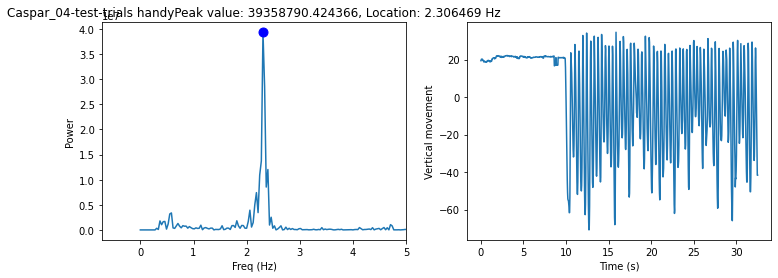

[75, 17330423.75301303, 10070926.078353425, 3201884.8796975715, 2010479.5830057734, 29, 'Success']
1.388969521044993
powers
[2325209.1798462044, 1620185.5109923165, 4167363.770232493, 274010750.84973145]


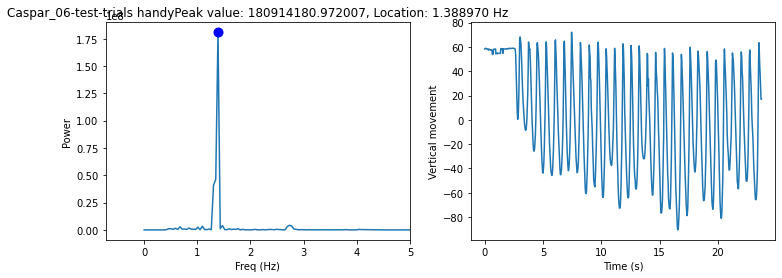

[33, 2325209.1798462044, 1620185.5109923165, 4167363.770232493, 274010750.84973145, 29, 'Success']
2.1925820256776034
powers
[13248085.377192436, 20216488.40008919, 1838608.3349816857, 1495801.0100977216]


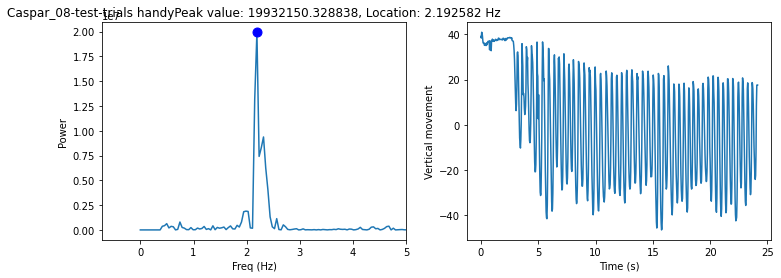

[53, 13248085.377192436, 20216488.40008919, 1838608.3349816857, 1495801.0100977216, 29, 'Success']
1.601492537313433
powers
[567715.0710423766, 3059380.1445625466, 127821174.09620139, 117260500.81397234]


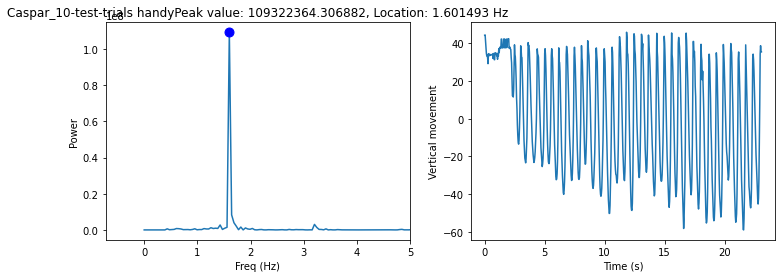

[37, 567715.0710423766, 3059380.1445625466, 127821174.09620139, 117260500.81397234, 29, 'Success']
2.6986706056129983
powers
[20750551.160735667, 752351.1043585939, 623773.8931504518, 1004161.2669569298]


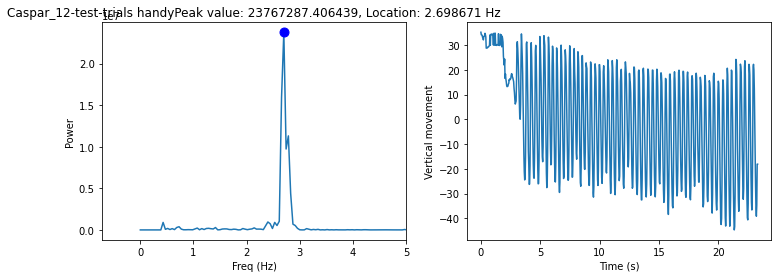

[63, 20750551.160735667, 752351.1043585939, 623773.8931504518, 1004161.2669569298, 29, 'Success']
2.528525296017223
powers
[129401359.0121565, 14682489.995852541, 6331939.602677266, 5966690.206007564]


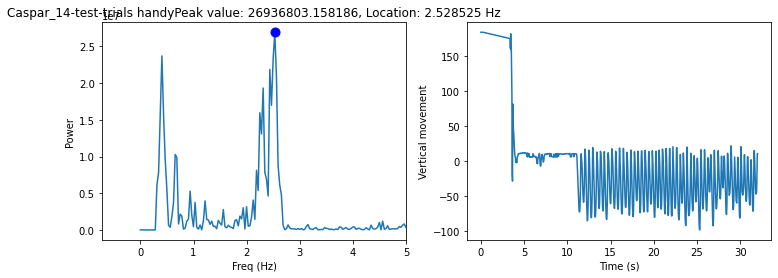

[81, 129401359.0121565, 14682489.995852541, 6331939.602677266, 5966690.206007564, 29, 'Success']
1.0979547900968782
powers
[12659516.067570042, 17403460.231660224, 30353374.67524019, 68845609.61583944]


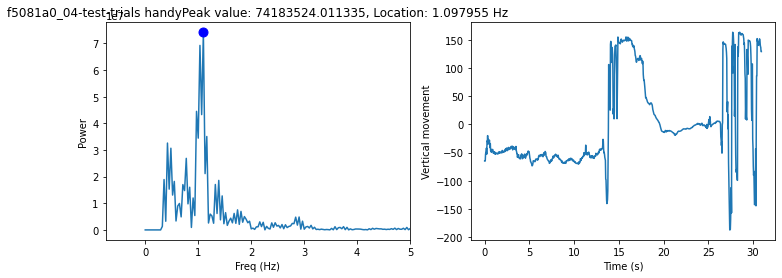

[34, 12659516.067570042, 17403460.231660224, 30353374.67524019, 68845609.61583944, 30, 'Success']
0.4792332268370607
powers
[18606328.985573754, 18088238.655413873, 14508420.192036629, 21233384.668042097]


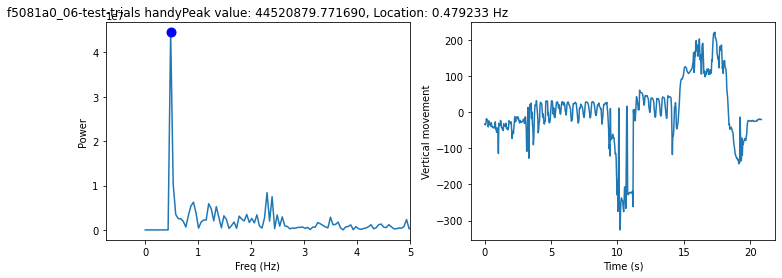

[10, 18606328.985573754, 18088238.655413873, 14508420.192036629, 21233384.668042097, 30, 'Success']
1.7480314960629921
powers
[13657115.80263632, 53686235.81608371, 98371808.7996496, 15561734.532479208]


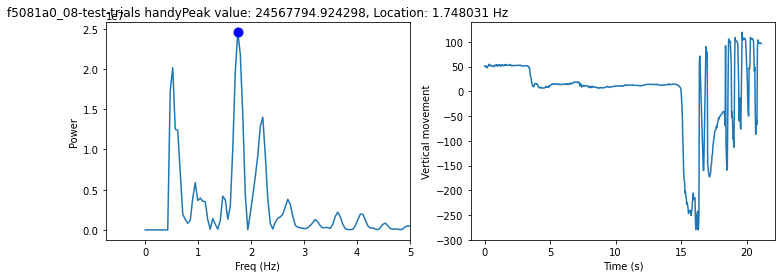

[37, 13657115.80263632, 53686235.81608371, 98371808.7996496, 15561734.532479208, 30, 'Success']
0.6944444444444444
powers
[6524519.996900328, 16340934.099221198, 16009150.051390413, 31438956.402585838]


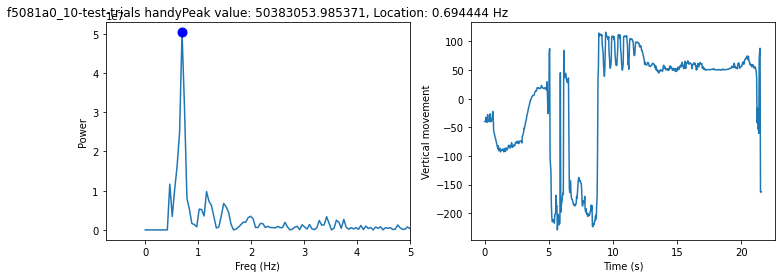

[15, 6524519.996900328, 16340934.099221198, 16009150.051390413, 31438956.402585838, 30, 'Success']
0.6009244992295839
powers
[15338956.740023183, 25948771.619073927, 14090169.382875975, 16221553.850944355]


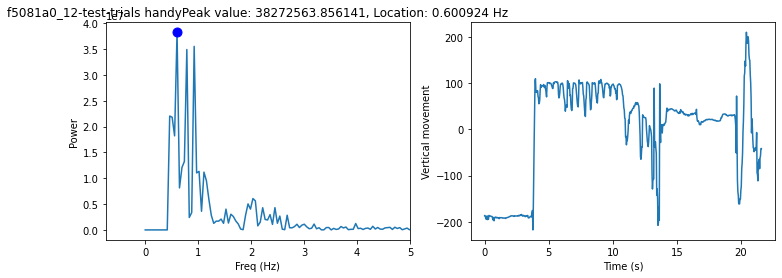

[13, 15338956.740023183, 25948771.619073927, 14090169.382875975, 16221553.850944355, 30, 'Success']
2.219804134929271
powers
[27984287.406219006, 36499515.482952796, 11878421.729954218, 13395469.401449814]


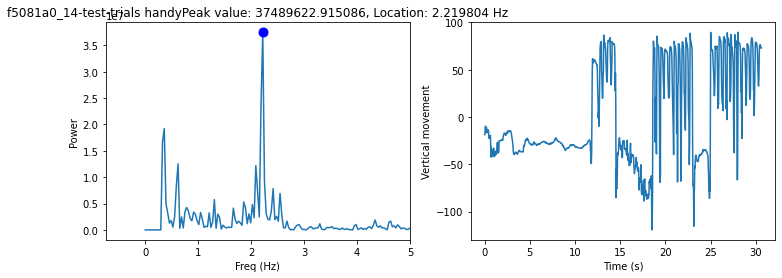

[68, 27984287.406219006, 36499515.482952796, 11878421.729954218, 13395469.401449814, 30, 'Success']
0.39565217391304347
powers
[296616.11233573814, 488677.2621764624, 549649.7769800948, 1008840.5911381436]


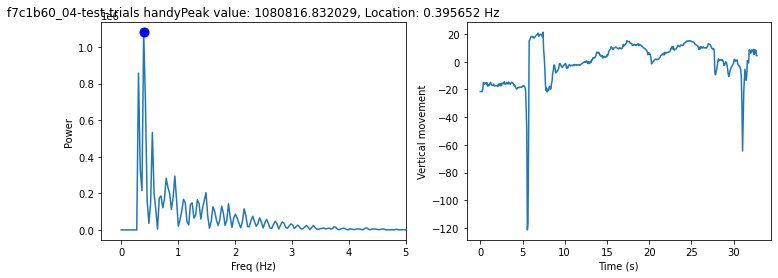

[13, 296616.11233573814, 488677.2621764624, 549649.7769800948, 1008840.5911381436, 14, 'Success']
0.42704626334519574
powers
[4622.554225433512, 3690.145499618213, 5694.963135878153, 9160.466234839325]


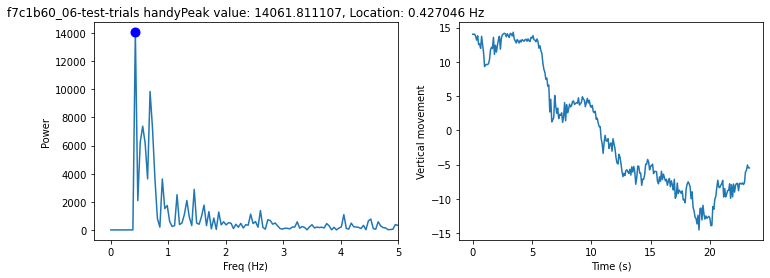

[10, 4622.554225433512, 3690.145499618213, 5694.963135878153, 9160.466234839325, 12, 'Success']
0.5187319884726225
powers
[81586.72327195437, 195439.5652163009, 157652.3514983085, 143584.4067147968]


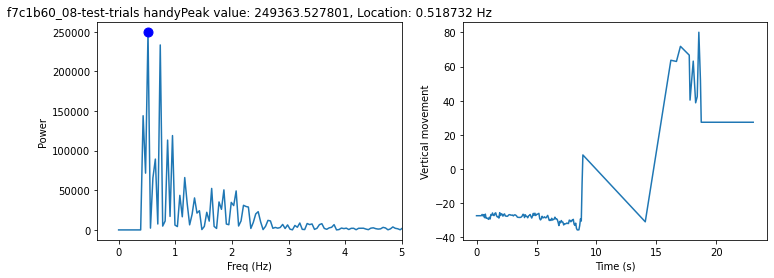

[12, 81586.72327195437, 195439.5652163009, 157652.3514983085, 143584.4067147968, 15, 'Success']
0.4395604395604396
powers
[37532.701206354424, 19124.93528638722, 193027.74073615434, 190262.16293419513]


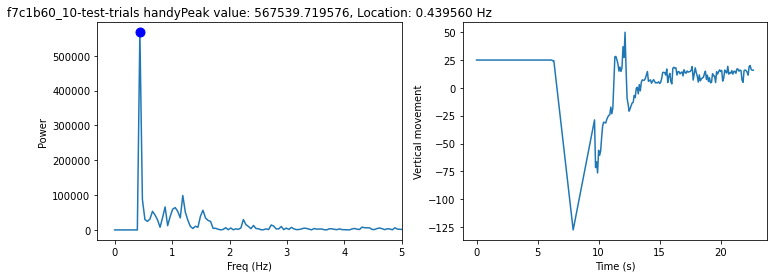

[10, 37532.701206354424, 19124.93528638722, 193027.74073615434, 190262.16293419513, 12, 'Success']
0.537593984962406
powers
[250539.49796452018, 403884.3706390423, 486518.0200900657, 682493.1906585124]


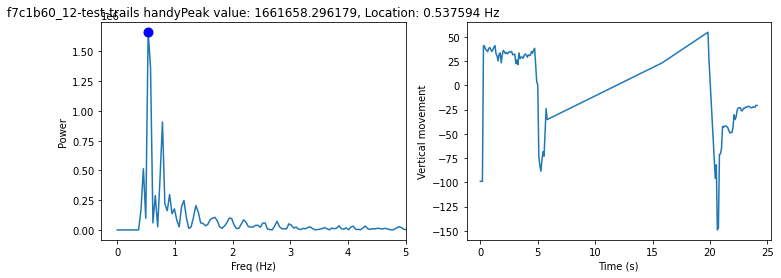

[13, 250539.49796452018, 403884.3706390423, 486518.0200900657, 682493.1906585124, 11, 'Success']
0.32526881720430106
powers
[349976.5266508441, 955534.8514426072, 786751.5544340813, 2322112.27527502]


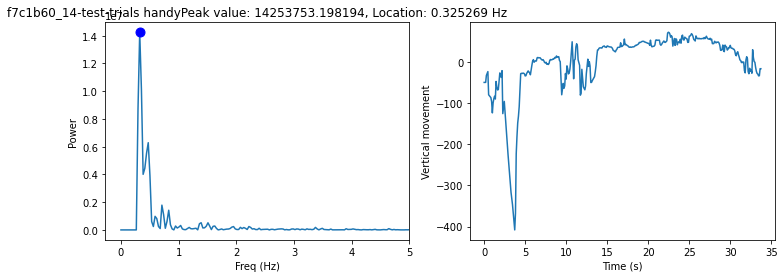

[11, 349976.5266508441, 955534.8514426072, 786751.5544340813, 2322112.27527502, 11, 'Success']
2.303030303030303
powers
[24081949.154389884, 177098374.3434374, 19201763.734297175, 17211390.214318763]
sinead_04-test-trials  Error:  x and y must have same first dimension, but have shapes (957,) and (956,)
[nan, nan, nan, nan, nan, 29, 'x and y must have same first dimension, but have shapes (957,) and (956,)']
1.4011713030746706
powers
[10306609.41730311, 22932920.694504097, 56300153.02937039, 1069241777.5023745]


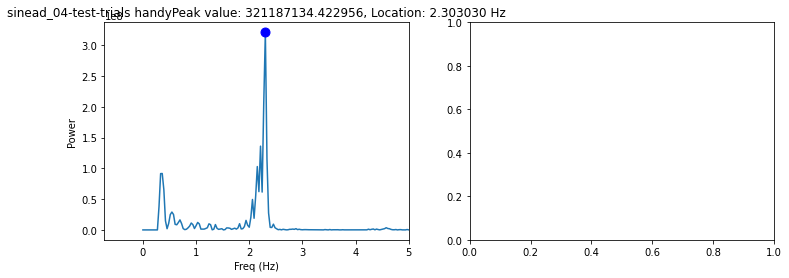

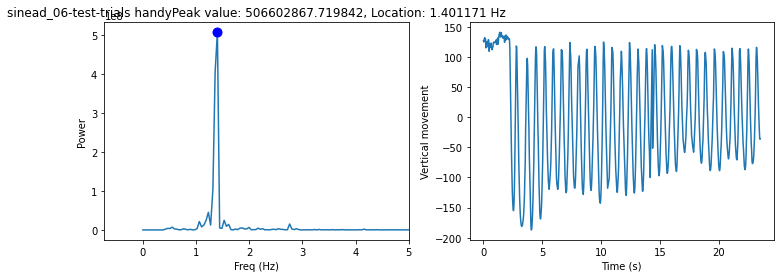

[33, 10306609.41730311, 22932920.694504097, 56300153.02937039, 1069241777.5023745, 29, 'Success']
1.9219440353460973
powers
[1383718.3646741111, 330288602.71345454, 10137884.488577113, 5952839.9559176]


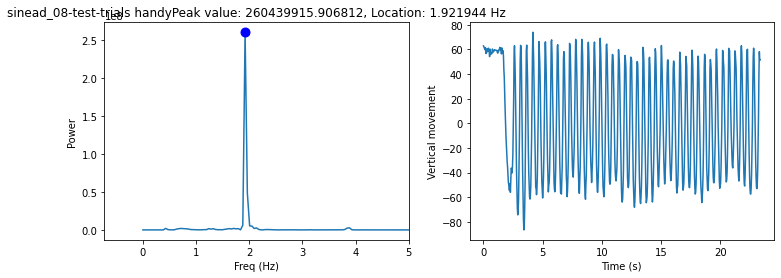

[45, 1383718.3646741111, 330288602.71345454, 10137884.488577113, 5952839.9559176, 29, 'Success']
1.6205882352941177
powers
[830389.816328905, 3186862.635606358, 309889655.36420596, 70369019.80889817]


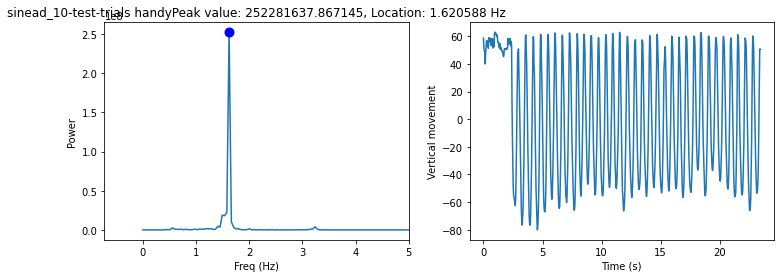

[38, 830389.816328905, 3186862.635606358, 309889655.36420596, 70369019.80889817, 29, 'Success']
2.4021084337349397
powers
[196166127.90338948, 7406607.138642111, 4334720.440646727, 5073792.640875893]


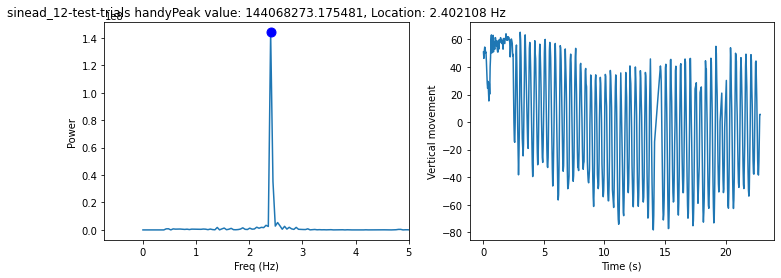

[55, 196166127.90338948, 7406607.138642111, 4334720.440646727, 5073792.640875893, 29, 'Success']
2.1001540832049304
powers
[8351713.287853285, 232316484.89475125, 28335333.585449807, 32033691.161494367]


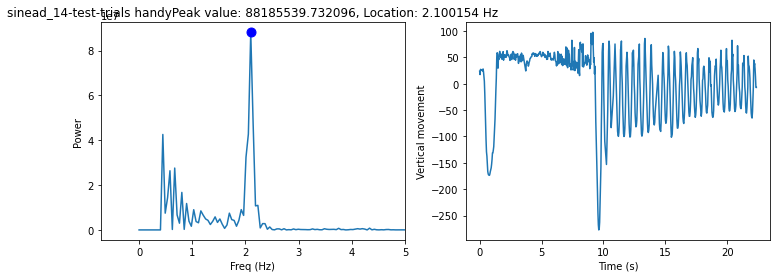

[47, 8351713.287853285, 232316484.89475125, 28335333.585449807, 32033691.161494367, 29, 'Success']
1.7400644468313642
powers
[91427672.54289709, 633843198.7882198, 4063056900.615098, 761174845.1496608]


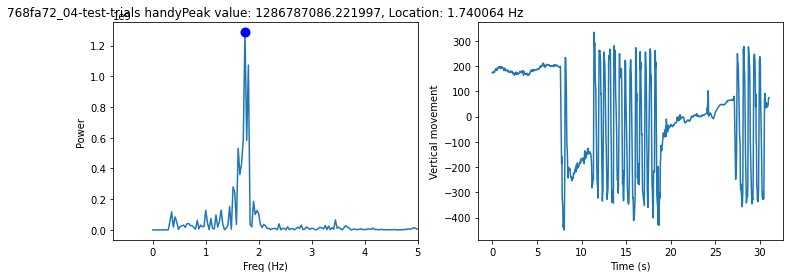

[54, 91427672.54289709, 633843198.7882198, 4063056900.615098, 761174845.1496608, 30, 'Success']
1.218045112781955
powers
[258049613.94869936, 509146148.198977, 674872148.0741444, 673868470.7808399]


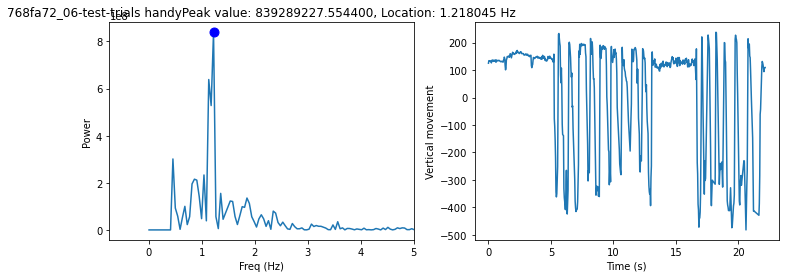

[27, 258049613.94869936, 509146148.198977, 674872148.0741444, 673868470.7808399, 30, 'Success']
1.2727272727272727
powers
[65484874.596674554, 92914299.21973728, 590603589.2530252, 1535191132.463564]


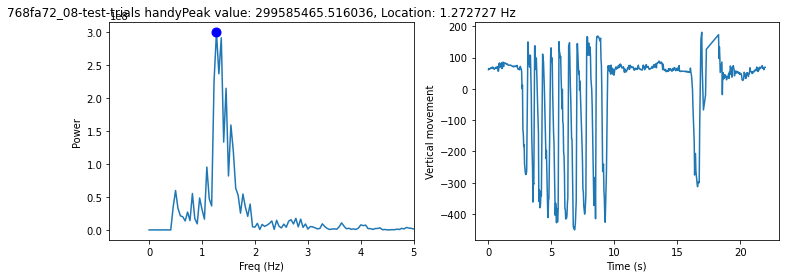

[28, 65484874.596674554, 92914299.21973728, 590603589.2530252, 1535191132.463564, 30, 'Success']
1.9188767550702028
powers
[3278219.260368017, 7403855.744012516, 4511686.514635469, 4133754.28869569]


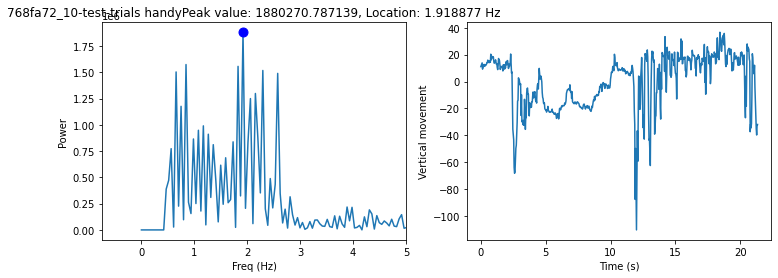

[41, 3278219.260368017, 7403855.744012516, 4511686.514635469, 4133754.28869569, 30, 'Success']
0.5750798722044728
powers
[1811821.7350515095, 3436358.792357797, 4453845.154984024, 7582172.767084339]


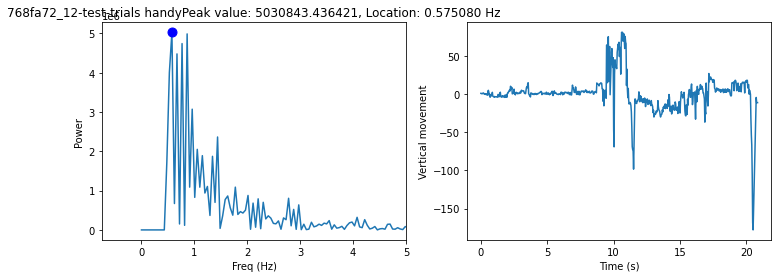

[12, 1811821.7350515095, 3436358.792357797, 4453845.154984024, 7582172.767084339, 30, 'Success']
0.32608695652173914
powers
[170771001.27942678, 417957062.1540349, 1169377332.0508137, 214816170.2720227]


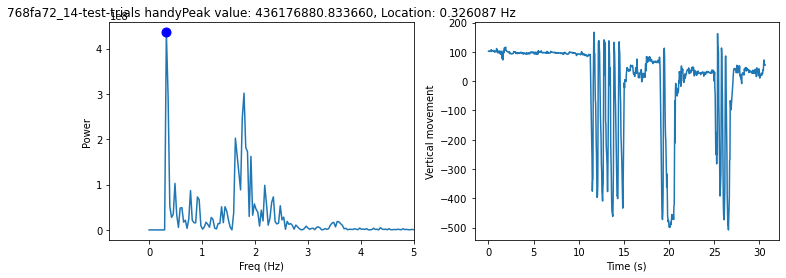

[10, 170771001.27942678, 417957062.1540349, 1169377332.0508137, 214816170.2720227, 30, 'Success']


In [20]:
import scipy.fft

plotgraphs = True
showfirstguess = False
savedata = True
GuessSMT  = 450  #we expect infants to have a spontaneous ISI of 450 ms
GuessFreq = 1000/GuessSMT

bodypart = 'handy'

failarray = [math.nan, math.nan, math.nan, math.nan,math.nan]  #empty array if we fail to fit function

results = pd.DataFrame(columns = ("peak", "400","500","600","700","fps","message"), index = videos)

halfbinwidth = 4
targetFreqs = [1000/400, 1000/500, 1000/600, 1000/700]
freqResults =pd.DataFrame(columns = ("ISI400","ISI500","ISI600","ISI700"))


for vid in videos:
    #retrieve the raw data for this video
    frames = videos[vid]['camera1']['frames']    #how many frames?
    fps = videos[vid]['camera1']['fps']          #how many frames per second?
    x_data = np.linspace(0,frames,frames+1)      #x axis
    x_time = x_data / fps                        #x axis in units of time (seconds)
    armmov = avgrh[(vid, people[0], bodypart)]  #get the averaged data
    y_data = armmov.truncate(before = 0, after = frames).to_numpy()  #convert to numpy array
    
    #we are just interested in the periodic elements (not absolute value above zero) so substract the mean
    y_normed = np.subtract(y_data,np.average(y_data))
    
    try:  
        yf = scipy.fft.rfft(y_normed)
        power = np.abs(yf)**2
        xf = scipy.fft.rfftfreq(x_data.size, 1 / fps)
        
        #cutoff at the lower end as these frequencies are not relevant
        power[0:10] = 0

        #let's find the maximum frequency. 
        #we hope this is infant's repetitive movement
        mY = np.abs(power) # Find magnitude
        peakY = np.max(mY) # Find max peak
        locY = np.argmax(mY) # Find its location
        frqY = xf[locY] # Get the actual frequency value
        print(frqY)
        
        #let's find the power in a given frequency bucket corresponding to target freq
        powers = [0,0,0,0]
        for p in range(4):
            #find the nearest value in our list to
            bucket = np.argmax(xf>targetFreqs[p])
            powers[p] = sum(mY[bucket-halfbinwidth:bucket+halfbinwidth])

        print("powers")
        print(powers)
        
        if plotgraphs:
            plt.figure(figsize=(12, 4),)
            plt.subplot(1,2,1)
            plt.plot(xf, power)
 
            # New - Plot the max point
            plt.plot(frqY, peakY, 'b.', markersize=18)
            # Rest of the code is the same
            plt.xlabel('Freq (Hz)')
            plt.ylabel('Power')
            plt.xlim(right=5)
            #make title reflecting peak information
            plt.title(vid + " " + bodypart + 'Peak value: %f, Location: %f Hz' % (peakY, frqY))

            plt.subplot(1,2,2)
            plt.plot(x_time, y_normed)
            plt.xlabel('Time (s)')
            plt.ylabel('Vertical movement')
            plt.show()


        if savedata:
            #save all values to dataframe
            vals = [locY] 
            vals.extend(powers)
            vals.append(fps)
            vals.append("Success")
            print(vals)
            results.loc[vid] = vals


    except Exception as e:
        #emsg = "".join(str(e)) #error message string hack :(
        emsg = str(e)
        #show the error
        print(vid, " Error: ",emsg)
        if savedata:
            #record error in our results array
            vals = failarray.copy()
            vals.append(fps)
            vals.append(emsg)
            print(vals)
            results.loc[vid] = vals

In [17]:
#save the fitted parameters.
results.to_excel("RightHand.FixedBinFreq.xlsx")

In [ ]:
subsetvids = []
count = 0
for vid in videos:
    subsetvids.append(vid)
    count += 1
    if count > 12:
        break
    
print(subsetvids)

## 3.4 Comparing to human coding. 

We have a spreadsheet of syhnchrony scores for each parent infant dyad. Here we see if we can find a measure that correlates with the human scores.

First, load up the spreadsheet..

In [ ]:
excelpath = projectpath + "\\SS_CARE.xlsx"

filename, file_format = os.path.splitext(excelpath)
if file_format and file_format == 'xls':
    # use default reader 
    videolist = pd.read_excel(excelpath)
else: 
    #since dec 2020 read_excel no longer supports xlsx (!?) so need to use openpyxl like so..
    videolist = pd.read_excel(excelpath, engine = "openpyxl")
    
videolist = videolist.set_index("subject")

In [ ]:
#take a quick look
videolist

In [ ]:
#copy the dyad syncrhony and maternal sensitivity scores into our data frame.
results["DyadSynScore"] = videolist["DyadSyn"]
results["MatSensScore"] = videolist["MatSens"]

In [ ]:
#take a quick look
results

In [ ]:
#scatter plots of these results. 
plt.scatter(results["DyadSynScore"],results["corrArms"], )
plt.title("Correlation between expert rated synchrony and time series correlations")
plt.xlabel("Dyad Synchroncy Score")
plt.ylabel("Dyad Correlation")
plt.show()

In [ ]:
rolling_r.mean()

So 

In [ ]:


d1 = vardf[(vid, who[0], parts[0])]
d2 = vardf[(vid, who[1], parts[0])]
seconds = 5
fps = 25
wholeads = who[0] + 'leads <> ' + who[1] + ' leads'
rs = [vasc.crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\n' + wholeads,ylim=[.0,1],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);
plt.legend()

## 3.4 Granger Causality

The next thing to look at is if the movements of the infant predict the movements of the parent. This would suggest parent is responding to the infant. 


In [ ]:

https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

https://www.machinelearningplus.com/time-series/time-series-analysis-python/
    
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
    